# Code

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
plotly.tools.set_credentials_file(username='Yiming_Gao', api_key='8aK9bpc31YdCuAqEBv7m')
# import visJS2jupyter.visJS_module

from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.models import Model,MLP
from gcn.layers import *

import scipy.sparse as sp
import random

### Input 1: Preferential Attachment Model

- Model: Preferential Attachment Model
- Learning Rate = 0.05
- Drop-out Rate = 0.5
- Cost function: masked_huber_loss (delta = 5e-2)
- Evaluation function: masked_accuracy (actually it is MSE)
- Adjacency matrix: A
- Weight decay: Yes

Result: test mse = 2.855006e-07

Plot: Input1

In [4]:
G_temp = nx.barabasi_albert_graph(1000, 1)
G = nx.DiGraph()
G.add_edges_from(G_temp.edges()) # convert to directed model
pr = nx.pagerank(G, alpha = 0.85) 
for i in pr.keys():
    G[i]['score']=pr[i]
    
n = len(G.nodes()) # number of nodes

### Input 2: Small World Model with Low Rewiring Probability (0.05)

- Model: Small World Model with Low Rewiring Probability (0.05)
- Learning Rate = 0.05
- Drop-out Rate = 0.5
- Cost function: masked_huber_loss (delta = 5e-2)
- Evaluation function: masked_accuracy (actually it is MSE)
- Adjacency matrix: A
- Weight decay: Yes

Result: test mse = 4.699519e-07

Plot: Input2

In [2]:
G_temp = nx.watts_strogatz_graph(1000, 10, 0.05) # Small world with low rewiring probability
# G_temp = nx.watts_strogatz_graph(1000, 10, 0.9) # Small world with high rewiring probability

# initialize an empty directed graph
G = nx.DiGraph()
G.add_edges_from(G_temp.edges())

pr = nx.pagerank(G, alpha = 0.85) 
for i in pr.keys():
    G[i]['score']=pr[i]

n = len(G.nodes()) # number of nodes

### Input 4: Stanford Web Data

In [2]:
with open("web-Stanford.txt","r") as fil:
    for _ in range(4):
        next(fil)
    data=[tuple([int(j) for j in i.strip().split()]) for i in fil]

In [3]:
G = nx.DiGraph()
G.add_edges_from(data)

pr = nx.pagerank(G, alpha=0.9)   #作为true response?

In [4]:
for i in pr.keys():
    G[i]['score']=pr[i]

In [5]:
G[1]['score']

3.561215144991757e-07

In [6]:
n=len(G.nodes())

A Sidenote:

要解释什么是damping factor:

The damping factor is the click-through probability, is included to prevent sinks (i.e. pages with no outgoing links) from "absorbing" the PageRanks of those pages connected to the sinks.  
- You can see that if it equals to 1, the person clicking will click forever and they will always end up in a sink. 

- On the other hand, if the click-through probability is 0, then all clicks are random restarts, which are uniformly distributed.

So, a damping factor is a weighted average between the two extremes.

### Preferential Attachment Model
命名和上一个一样，可以先拿以下的代码试验，数据小跑起来比较快

## Simple Neural Network

### 测试前要看一下
+ 之前学习率填了0.05，明显训练的时候有了误差来回变大减小又变大再减小的情况，应该要调小一点，之前作业里是0.01,我一时兴起又改大了……
+ 用networkx里的pagerank算法出来的分数是在0-1之间，所以最后的误差出来即使是0.几，也不确定是不是很好，这里是100个点做validation。
+ epoch可能也要调，学习率0.05的时候300差不多收敛了，但是不知道学习率改了之后是什么情况

In [3]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'  #这行应该并没有什么用
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_float('learning_rate', 0.05, 'Initial learning rate.')
#flags.DEFINE_float('learning_rate', 0.1, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 300, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
#flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
#flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 100, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

If you assume the target is continuous (like PageRank scores here) and normally distributed, and you maximize the likelihood of the output of the net under these assumptions, you get the MSE (combined with a linear output layer).

In [4]:
# loss function 1
def masked_mean_square_error(preds,labels,mask):
    """L2 loss with masking."""
    loss = tf.nn.l2_loss(preds - labels)   
    # loss = tf.nn.relu(preds - labels) Rulu loss
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

# loss function 2
def masked_absolute_difference(preds,labels,mask):
    """Absolute Loss (L1 Loss) with masking"""
    loss = tf.losses.absolute_difference(labels = labels, predictions = preds)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

# loss function 3
def masked_huber_loss(preds,labels,mask):
    """Huber with masking"""
    # https://davidrosenberg.github.io/ml2015/docs/3a.loss-functions.pdf
    err = tf.abs(preds - labels)
    delta = tf.constant(5e-1)
    quad = 0.5 * tf.square(err) # quadratic
    lin = err - 0.5 # linear
    loss = tf.where(err < delta, quad, lin)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

#------------- Output layer: loss function for regression: squared loss -----------------#
# Mean Square Error
def masked_accuracy(preds, labels, mask):
    """Root Mean Square Error with masking"""
    rmse = tf.squared_difference(preds, labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    rmse *= mask
    return tf.reduce_mean(rmse)

**Cross Entropy vs. Mean Square Error**

Cross-entropy is prefered for **classification**, while mean squared error is one of the best choices for **regression**. This comes directly from the statement of the problems itself - in classification you work with very particular set of possible output values thus MSE is badly defined (as it does not have this kind of knowledge thus penalizes errors in incompatible way). 

In [5]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # loss function 1
        # self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
                                                 # self.placeholders['labels_mask'])
        
        # loss function 2
        # self.loss += masked_absolute_difference(self.outputs, self.placeholders['labels'],
                                                # self.placeholders['labels_mask'])
        
        # loss function 3
        self.loss += masked_huber_loss(self.outputs, self.placeholders['labels'],
                                       self.placeholders['labels_mask'])
        

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return self.outputs    #tf.nn.softmax(self.outputs)

In [6]:
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)

# A^2
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)

In [7]:
# Randomly generate graph with 500 nodes
adj = nx.adjacency_matrix(G)

# Generate feature matrix  #there is difference between different version of networkx, 这里是用networkx 2.0. 原来1.1的用法注释掉了
#features = sp.vstack(list(j[1] for j in G.in_degree(G.nodes())),dtype = 'float32').tolil()
features = sp.vstack(list(G.in_degree(G.nodes()).values()),dtype = 'float32').tolil()   

# Feed labels to 20 nodes
label = []
for i in G.nodes():
    #label.append(G.nodes[i]['score']) 我用的1.1语法-yiming
    label.append(G[i]['score'])
        
alabel = np.array(label, dtype='float64')

idx_train = range(700)
idx_val = range(700, 700 + 100) #20000改到500 for preferential attachment model
idx_test = range(800, 1000)

y_train = np.zeros([n, 1])   # n is number of total nodes
train_mask = np.zeros([n, ], dtype = 'bool')
for i in idx_train:
    y_train[i] = alabel[i]
    train_mask[i] = True

y_val = np.zeros([n, 1])
val_mask = np.zeros([n, ], dtype = 'bool')
for i in idx_val:
    y_val[i] = alabel[i]
    val_mask[i] = True
    
# Test data
y_test = np.zeros([n, 1])
test_mask = np.zeros([n, ], dtype = 'bool')
for i in idx_test:
    y_test[i] = alabel[i]
    test_mask[i] = True

In [8]:
# Load data
#adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

/Users/Yiming/Desktop/Homework/IE 532/Project/gcn/utils.py:97: RuntimeWarning:

divide by zero encountered in power



In [9]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_rmse = []
validation_rmse = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_rmse.append(acc)
    train_loss.append(outs[1])
    train_rmse.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_rmse=", "{:e}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_rmse=", "{:e}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 0.02465 train_rmse= 5.675634e-02 val_loss= 0.01579 val_rmse= 3.106000e-02 time= 0.12954
Epoch: 0002 train_loss= 0.03068 train_rmse= 7.349420e-02 val_loss= 0.00561 val_rmse= 1.023926e-02 time= 0.09369
Epoch: 0003 train_loss= 0.02180 train_rmse= 4.775639e-02 val_loss= 0.00045 val_rmse= 6.564638e-05 time= 0.09283
Epoch: 0004 train_loss= 0.01979 train_rmse= 4.683458e-02 val_loss= 0.00214 val_rmse= 3.734998e-03 time= 0.12338
Epoch: 0005 train_loss= 0.01446 train_rmse= 2.942493e-02 val_loss= 0.00332 val_rmse= 6.080656e-03 time= 0.09673
Epoch: 0006 train_loss= 0.01599 train_rmse= 3.305041e-02 val_loss= 0.00062 val_rmse= 7.067452e-04 time= 0.09682
Epoch: 0007 train_loss= 0.00979 train_rmse= 2.005093e-02 val_loss= 0.00099 val_rmse= 1.530569e-03 time= 0.10965
Epoch: 0008 train_loss= 0.00762 train_rmse= 1.500590e-02 val_loss= 0.00229 val_rmse= 4.320221e-03 time= 0.10784
Epoch: 0009 train_loss= 0.00696 train_rmse= 1.367284e-02 val_loss= 0.00160 val_rmse= 3.074944e-03 time= 

Epoch: 0076 train_loss= 0.00003 train_rmse= 4.455271e-06 val_loss= 0.00003 val_rmse= 5.389464e-07 time= 0.11112
Epoch: 0077 train_loss= 0.00003 train_rmse= 6.483243e-06 val_loss= 0.00003 val_rmse= 4.590596e-07 time= 0.09588
Epoch: 0078 train_loss= 0.00003 train_rmse= 4.435870e-06 val_loss= 0.00003 val_rmse= 3.961817e-07 time= 0.12078
Epoch: 0079 train_loss= 0.00003 train_rmse= 5.162777e-06 val_loss= 0.00003 val_rmse= 3.518748e-07 time= 0.19015
Epoch: 0080 train_loss= 0.00003 train_rmse= 6.191902e-06 val_loss= 0.00003 val_rmse= 3.118207e-07 time= 0.15777
Epoch: 0081 train_loss= 0.00003 train_rmse= 5.803023e-06 val_loss= 0.00003 val_rmse= 2.961054e-07 time= 0.19220
Epoch: 0082 train_loss= 0.00003 train_rmse= 5.361429e-06 val_loss= 0.00003 val_rmse= 2.973682e-07 time= 0.10530
Epoch: 0083 train_loss= 0.00003 train_rmse= 4.682535e-06 val_loss= 0.00003 val_rmse= 2.980109e-07 time= 0.09649
Epoch: 0084 train_loss= 0.00003 train_rmse= 4.317052e-06 val_loss= 0.00003 val_rmse= 2.326605e-07 time= 

Epoch: 0151 train_loss= 0.00001 train_rmse= 1.532046e-06 val_loss= 0.00001 val_rmse= 3.818746e-07 time= 0.10444
Epoch: 0152 train_loss= 0.00001 train_rmse= 1.998352e-06 val_loss= 0.00001 val_rmse= 3.654287e-07 time= 0.09818
Epoch: 0153 train_loss= 0.00001 train_rmse= 1.498848e-06 val_loss= 0.00001 val_rmse= 3.515098e-07 time= 0.09485
Epoch: 0154 train_loss= 0.00001 train_rmse= 1.510765e-06 val_loss= 0.00001 val_rmse= 3.442260e-07 time= 0.11310
Epoch: 0155 train_loss= 0.00001 train_rmse= 1.822870e-06 val_loss= 0.00001 val_rmse= 3.281322e-07 time= 0.09476
Epoch: 0156 train_loss= 0.00001 train_rmse= 1.672924e-06 val_loss= 0.00001 val_rmse= 3.186494e-07 time= 0.09496
Epoch: 0157 train_loss= 0.00001 train_rmse= 1.942045e-06 val_loss= 0.00001 val_rmse= 2.996136e-07 time= 0.10495
Epoch: 0158 train_loss= 0.00001 train_rmse= 1.548048e-06 val_loss= 0.00001 val_rmse= 2.876961e-07 time= 0.09565
Epoch: 0159 train_loss= 0.00001 train_rmse= 1.620806e-06 val_loss= 0.00001 val_rmse= 2.862847e-07 time= 

Epoch: 0226 train_loss= 0.00000 train_rmse= 7.055637e-07 val_loss= 0.00000 val_rmse= 4.161975e-07 time= 0.14660
Epoch: 0227 train_loss= 0.00000 train_rmse= 6.688005e-07 val_loss= 0.00000 val_rmse= 4.107081e-07 time= 0.10771
Epoch: 0228 train_loss= 0.00000 train_rmse= 6.698025e-07 val_loss= 0.00000 val_rmse= 4.038278e-07 time= 0.12029
Epoch: 0229 train_loss= 0.00000 train_rmse= 6.187585e-07 val_loss= 0.00000 val_rmse= 3.969708e-07 time= 0.13006
Epoch: 0230 train_loss= 0.00000 train_rmse= 5.973146e-07 val_loss= 0.00000 val_rmse= 3.911606e-07 time= 0.10693
Epoch: 0231 train_loss= 0.00000 train_rmse= 6.910155e-07 val_loss= 0.00000 val_rmse= 3.824065e-07 time= 0.11322
Epoch: 0232 train_loss= 0.00000 train_rmse= 7.588906e-07 val_loss= 0.00000 val_rmse= 3.761326e-07 time= 0.15823
Epoch: 0233 train_loss= 0.00000 train_rmse= 5.807269e-07 val_loss= 0.00000 val_rmse= 3.695923e-07 time= 0.13770
Epoch: 0234 train_loss= 0.00000 train_rmse= 6.270296e-07 val_loss= 0.00000 val_rmse= 3.628730e-07 time= 

### Test

In [10]:
# Testing
test_cost, test_rmse, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f},".format(test_cost),
      "Mean square error=", "{:e},".format(test_rmse), "time=", "{:.5f}s.".format(test_duration))

Test set results: cost= 0.00000, Mean square error= 4.699519e-07, time= 0.04354s.


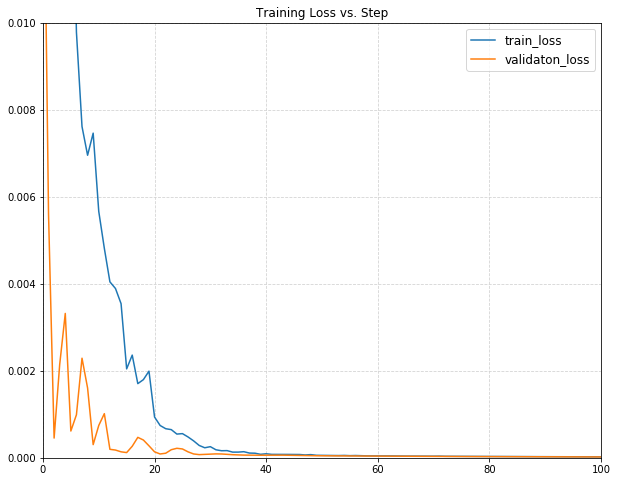

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_loss,label='validaton_loss')
plt.xlim(0, 100)
plt.ylim(0, 0.01)
plt.legend(prop={'size': 12})
plt.grid(color = 'lightgray', linestyle = '--')
plt.title('Training Loss vs. Step')
# plt.savefig("Input2loss.png") 
plt.show()

## Tuning Process
### Learning rate
**1.png** Stop at Epoch 174, test mse = 0.00001
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.01
- Drop-out Rate = 0.4
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes



**2.png** Stop at Epoch 148, test mse = 9.403576e-07
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.05
- Drop-out Rate = 0.4
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes


**3.png** Stop at Epoch 177, test mse = 4.968480e-07
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.1
- Drop-out Rate = 0.4
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes

### Drop-out rate
**4.png** Stop at Epoch 221, test mse = 4.405288e-06
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.05
- Drop-out Rate = 0.1
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes


**5.png** Stop at Epoch 196, test mse = 4.393734e-07
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.05
- Drop-out Rate = 0.5
- Cost function: masked_mean_square_error
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes
- 测试了好几次，到这里以上结果中case 5最理想(learning rate = 0.05, drop-out rate = 0.5), 以下的测试暂时基于这两个参数。

### Cost function
**6.png** Stop at Epoch 128, test mse = 4.955061e-07
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.05
- Drop-out Rate = 0.5
- Cost function: **masked_absolute_difference**
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes

**7.png** 
- Model: Small World Model (p = 0.05)
- Learning Rate = 0.05
- Drop-out Rate = 0.5
- Cost function: **masked_huber_loss**
    - 7-1: Delta = 5e-3 (Stop at Epoch 102, test mse = 2.845802e-07)
    - 7-2: Delta = 5e-2 (Stop at Epoch 102, test mse = 3.775311e-07)
    - 7-3: Delta = 5e-1 (Stop at Epoch 300, test mse = 3.015892e-07), probably performs the best 图片最好看
    - 7-4: Delta = 1 (Stop at Epoch 300, test mse = 3.739734e-07)
- Evaluation function: masked_accuracy (其实是RMSE)
- Adjacency matrix: A
- Weight decay: Yes

- 若learning rate = 0.01, train_loss一开始很大，在epoch = 100左右急剧减小
- 若learning rate = 0.05, train_loss一开始很大，在epoch = 20左右急剧减小

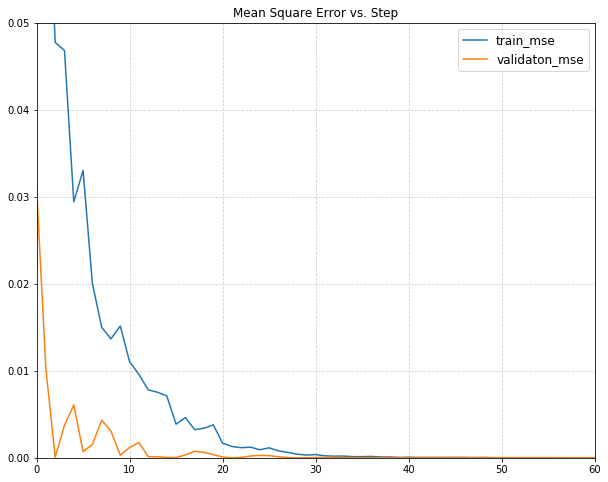

In [20]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(train_rmse,label = 'train_mse')
plt.plot(validation_rmse,label='validaton_mse')
plt.xlim(0, 60)
plt.ylim(0, 0.05)
plt.legend(prop={'size': 12})
plt.grid(color = 'lightgray', linestyle = '--')
plt.title('Mean Square Error vs. Step')
# plt.savefig("Input2mse.png") # 保存图片放在slides上
plt.show()

Presentation时可以做的几个比较 （保持其余参数尽可能结果最好）：

1. 不同的learning_rate (Yiming)
2. 不同的drop_out rate (Yiming)
3. 不同的Loss function (Yiming/ Yiqin)
4. 有无weight_decay (Yiqin)
5. 不同的adjacency matrix, A, A^2等等 (Yiqin)

这些是train on small graphs, test on large graph?? (stanford data)

Side note for Yiqin:
现在的evaluate我是用的root mean square error，可以参见上面的注释，可能还可以试一下别的evaluation function for continuous response.

我觉得presentation是图片越多越好，别人可能对定理没什么兴趣= =

谢谢你啦！！


*还需要test data